In [24]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid  # To generate a unique ID for each file
from tqdm import tqdm
from scipy.sparse import block_diag
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import random
from scipy.linalg import svd
from joblib import Parallel, delayed
from typing import List, Tuple
import seaborn as sns
import math
from matplotlib.colors import LinearSegmentedColormap
import random

In [2]:
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 
               'chr20', 'chr21', 'chr22', 'chrX']

In [3]:
def visualize(matrix, cmap='gray'):
    plt.imshow(matrix, cmap, interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("Block-Diagonal Chromosome Matrix")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

In [5]:
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

def find_range(data, chr):
    range_pos1 = data[data['chr1'] == chr]["pos1"]
    range_pos2 = data[data['chr2'] == chr]["pos2"]
    
    max_pos1 = range_pos1.max()
    min_pos1 = range_pos1.min() 
    max_pos2 = range_pos2.max() 
    min_pos2 = range_pos2.min() 

    max_range = max(max_pos1, max_pos2) - min(min_pos1, min_pos2)
    return int(max_range / 1000000) + 1, min(min_pos1, min_pos2)


def load_txt_to_matrix(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1'] - min_position) / 1000000)
                pos2_index = int((row['pos2'] - min_position) / 1000000)
                if abs(pos1_index - pos2_index) >= 3:
                    X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

In [46]:
sample = parse_file("GM12878/ml3_AAGCGACC-ACCTCTTG.txt")
sample_matrix_list = load_txt_to_matrix(sample)

In [ ]:
sample_matrix_list

In [17]:
# for i in range(23):
#     print(sample_matrix_list[i].shape)

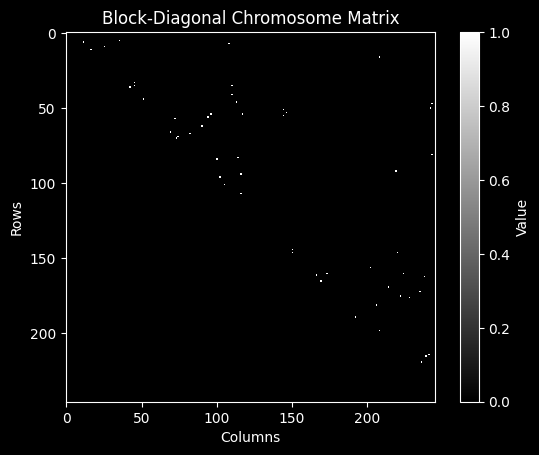

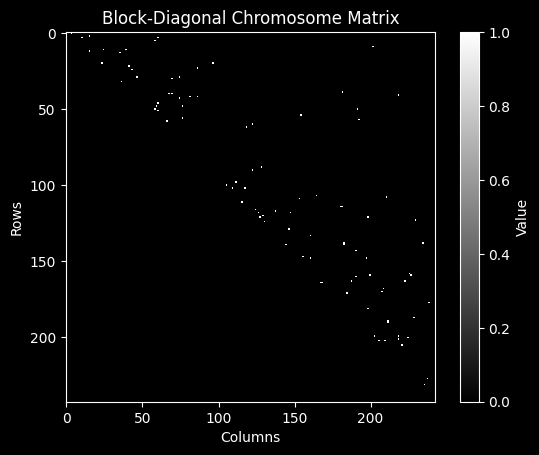

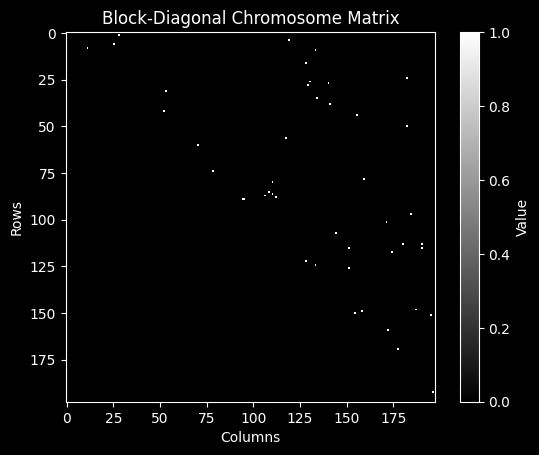

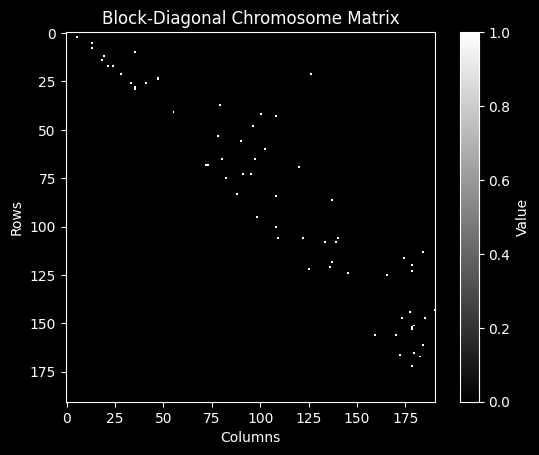

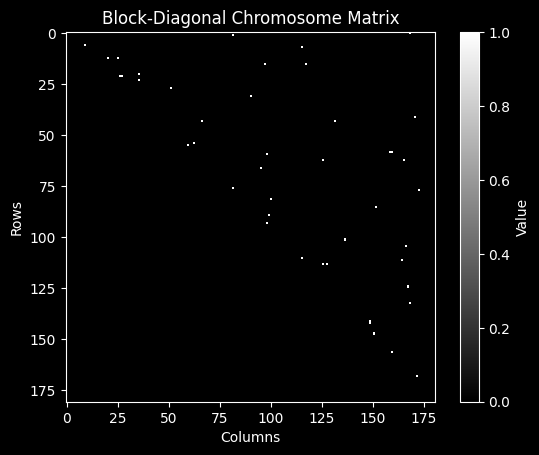

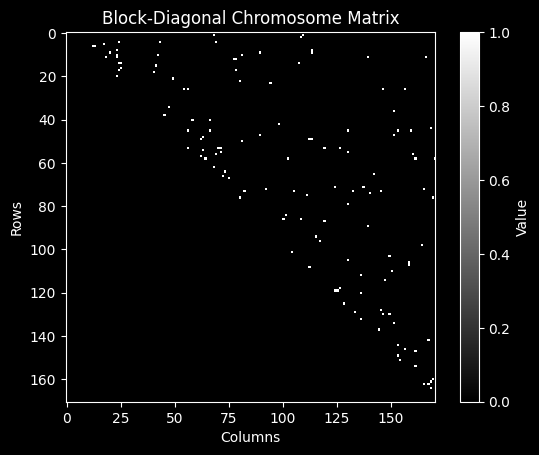

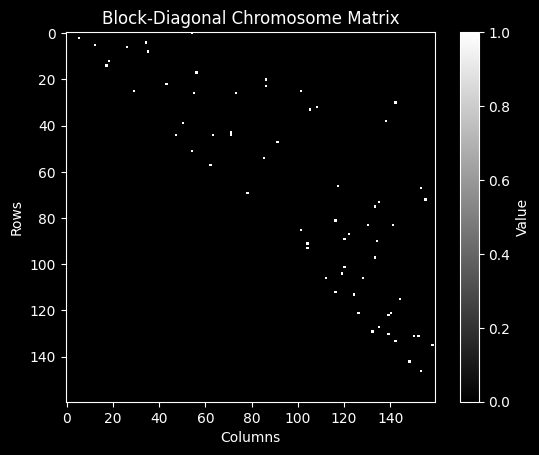

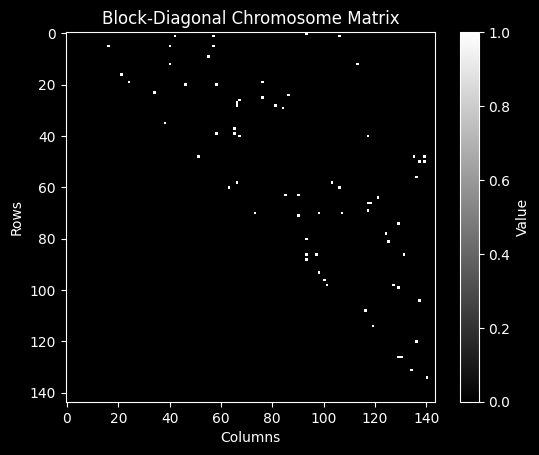

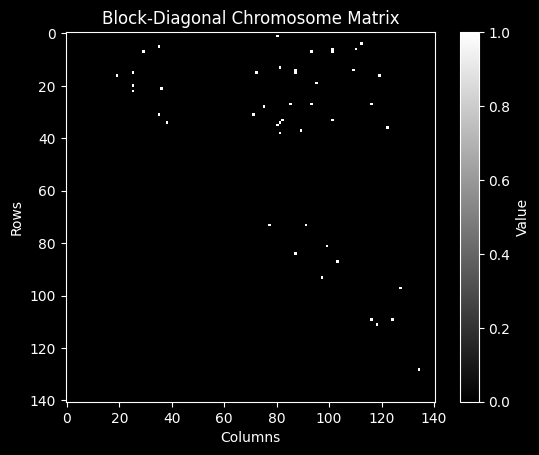

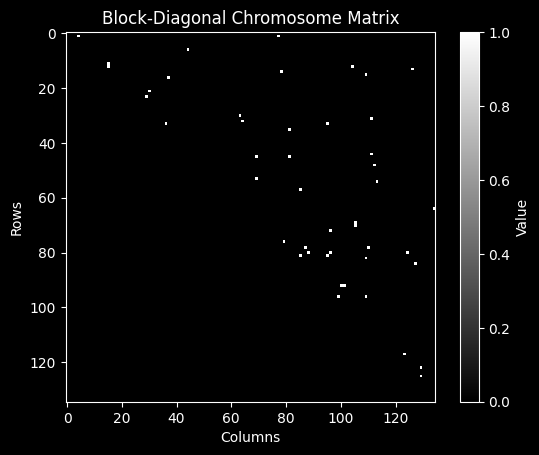

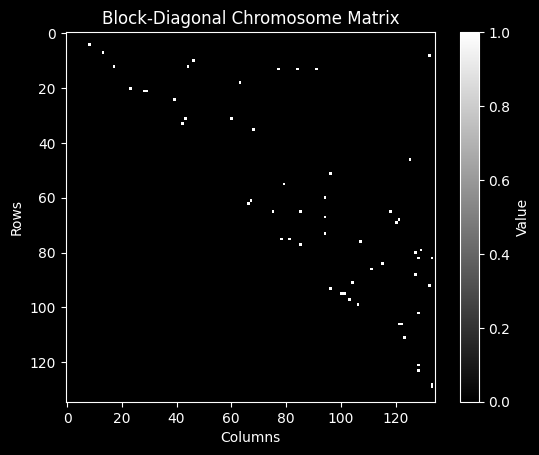

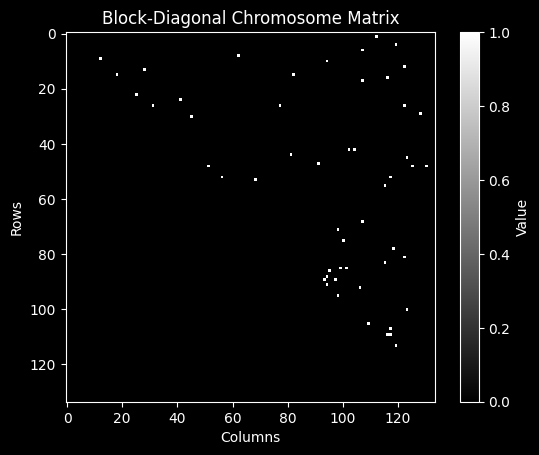

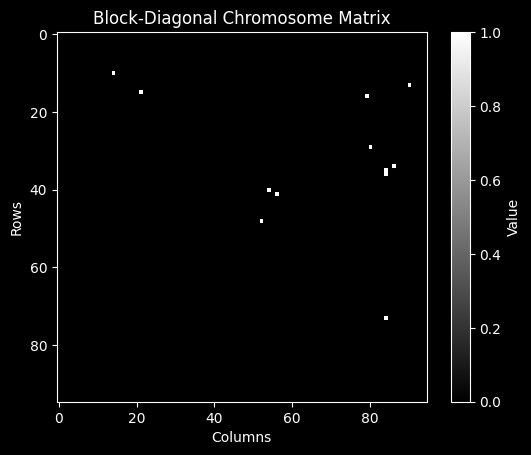

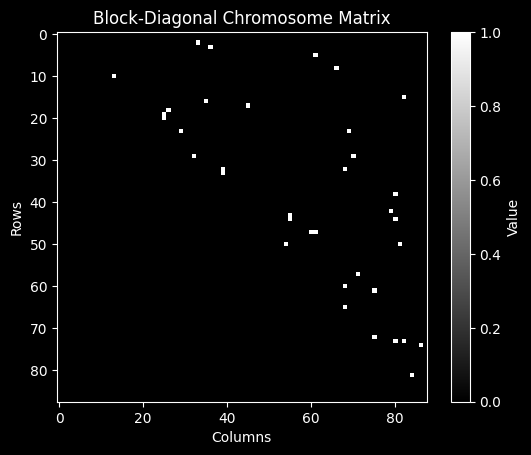

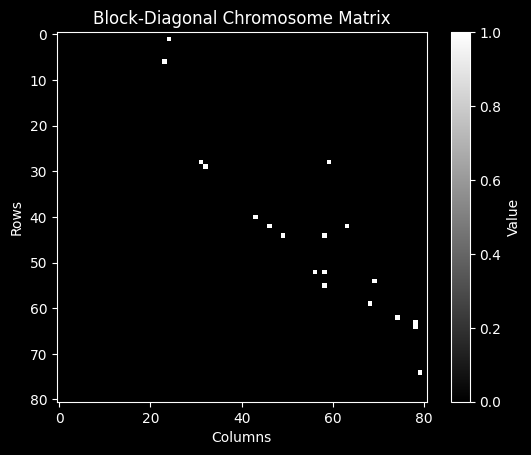

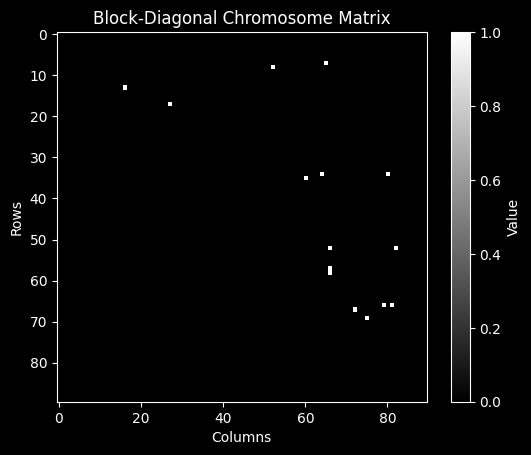

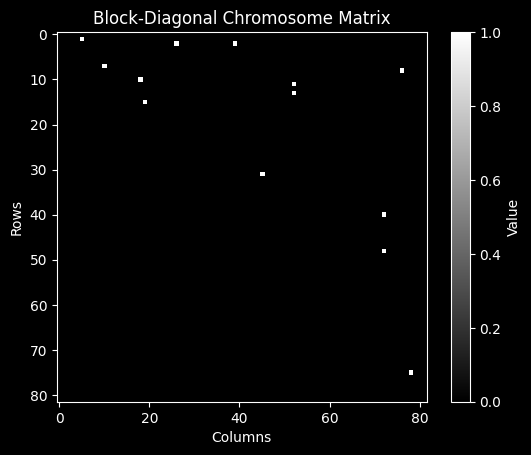

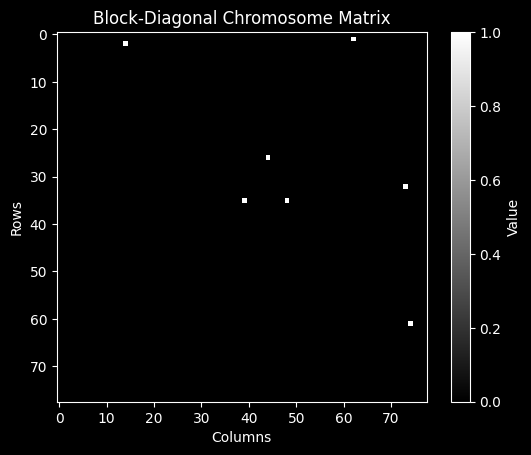

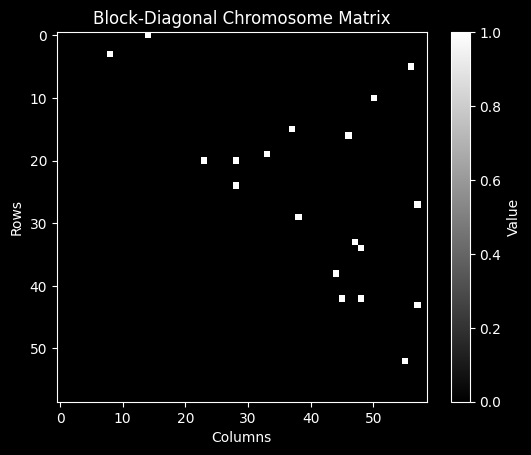

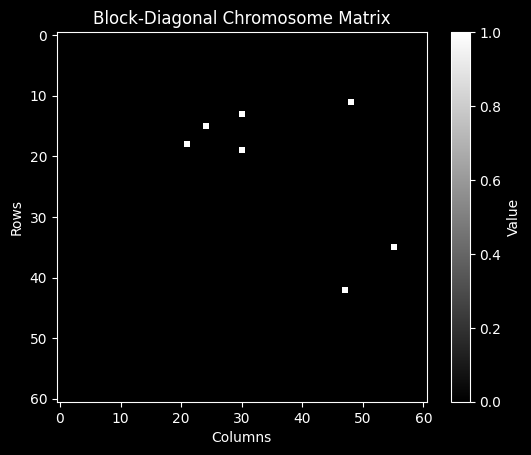

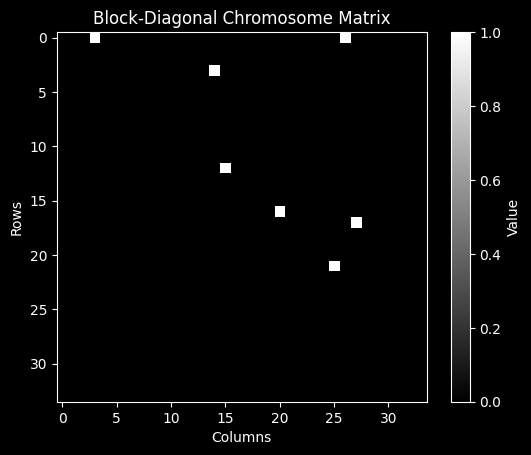

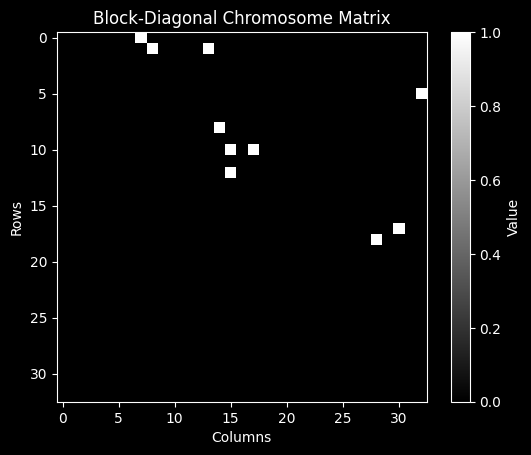

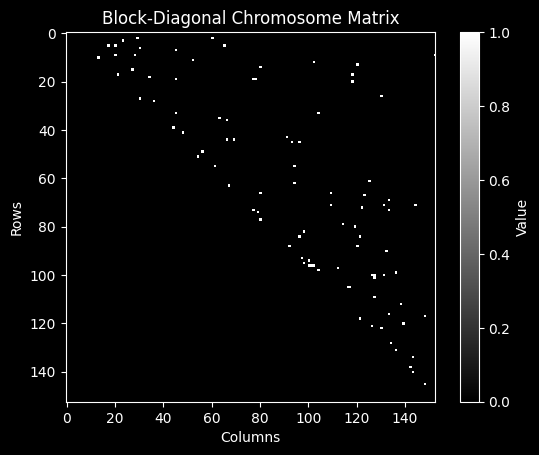

In [51]:
for i in range(23):
    visualize(sample_matrix_list[i])

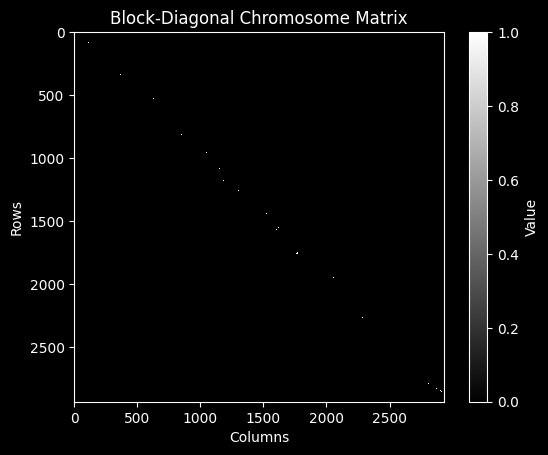

In [52]:
combined_matrix = block_diag(sample_matrix_list).toarray()
visualize(combined_matrix)

In [49]:
GM12878_MATRICES = []
HAP1_MATRICES = []
Hela_MATRICES = []
K562_MATRICES = []

for file in tqdm(os.listdir("GM12878")):
    if file.endswith(".txt"):
        data = parse_file(f"GM12878/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            GM12878_MATRICES.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("HAP1")):
    if file.endswith(".txt"):
        data = parse_file(f"HAP1/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            HAP1_MATRICES.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("Hela")):
    if file.endswith(".txt"):
        data = parse_file(f"Hela/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            Hela_MATRICES.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("K562")):
    if file.endswith(".txt"):
        data = parse_file(f"K562/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix(data)
            K562_MATRICES.append(block_diag(matrix_in_list).toarray())

100%|██████████| 48/48 [00:04<00:00, 10.11it/s]


In [6]:
# Function to perform PCA decomposition and return the reduced matrix and reconstructed matrix
def pca_reconstruct_and_distance(matrix, n_components=50):
    # Step 1: Center and normalize the matrix
    scaler = StandardScaler(with_mean=True, with_std=True)
    normalized_matrix = scaler.fit_transform(matrix)

    # Step 2: Apply PCA to reduce to `n_components` components
    pca = PCA(n_components=n_components)
    reduced_matrix = pca.fit_transform(normalized_matrix)
    
    # Step 3: Reconstruct the matrix back to the original dimensions
    reconstructed_matrix = pca.inverse_transform(reduced_matrix)
    
    # Step 4: Reverse normalization on the reconstructed matrix to match the original scale
    reconstructed_matrix = scaler.inverse_transform(reconstructed_matrix)
    
    # Step 5: Calculate the Frobenius norm (distance) between the original and reconstructed matrices
    distance = norm(matrix - reconstructed_matrix, ord='fro')
    
    return distance

In [7]:
# Function to calculate total distance for a list of matrices
def calculate_total_distance(matrix_list, n_components=50, sample_num=20):
    """
    Samples a subset of matrices from the provided list, computes the Frobenius distance
    for each, and returns the total sum of distances.
    
    Parameters:
    - matrix_list (list of np.ndarray): List containing matrices.
    - n_components (int): Number of principal components to retain in PCA.
    - sample_num (int): Number of matrices to sample from the list.
    
    Returns:
    - float: Total sum of Frobenius distances for the sampled matrices.
    """
    # Ensure sample_num does not exceed the number of available matrices
    sample_num = min(sample_num, len(matrix_list))
    
    # Sample a subset of matrices without replacement
    sampled_matrices = random.sample(matrix_list, sample_num)

    total_distance = 0.0
    for matrix in sampled_matrices:
        distance = pca_reconstruct_and_distance(matrix, n_components=n_components)
        total_distance += distance
    return total_distance

In [75]:
# Define the fraction or number of matrices to sample
sample_num = 20

# Sample a subset from HAP1 and Hela matrices
HAP1_sample = random.sample(HAP1_MATRICES, sample_num)
Hela_sample = random.sample(Hela_MATRICES, sample_num)
GM12878_sample = random.sample(GM12878_MATRICES, sample_num)
K562_sample = random.sample(K562_MATRICES, sample_num)


In [79]:
def plot_rank_to_loss():
    # Define the ranks to evaluate
    ranks = list(range(5, 51, 5))  # [5, 10, 15, ..., 50]
    sum_distances = []

    # Organize the matrices by cell line
    cell_lines = {
        'HAP1': HAP1_sample,
        'Hela': Hela_sample,
        'GM12878': GM12878_sample,
        'K562': K562_sample
    }

    # Initialize progress bar
    print("Computing total sum of Frobenius distances for each rank...")
    for rank in tqdm(ranks, desc="Ranks"):
        total_distance_sum = 0.0
        for matrix_list in cell_lines.values():
            distance = calculate_total_distance(matrix_list, n_components=rank, sample_num=20)
            total_distance_sum += distance
        sum_distances.append(total_distance_sum)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, sum_distances, marker='o', linestyle='-', color='blue')
    plt.title('Total Sum of Frobenius Distances vs PCA Rank', fontsize=14)
    plt.xlabel('Rank (Number of PCA Components)', fontsize=12)
    plt.ylabel('Total Sum of Frobenius Distances', fontsize=12)
    plt.xticks(ranks)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Computing total sum of Frobenius distances for each rank...


Ranks: 100%|██████████| 10/10 [1:39:44<00:00, 598.47s/it]


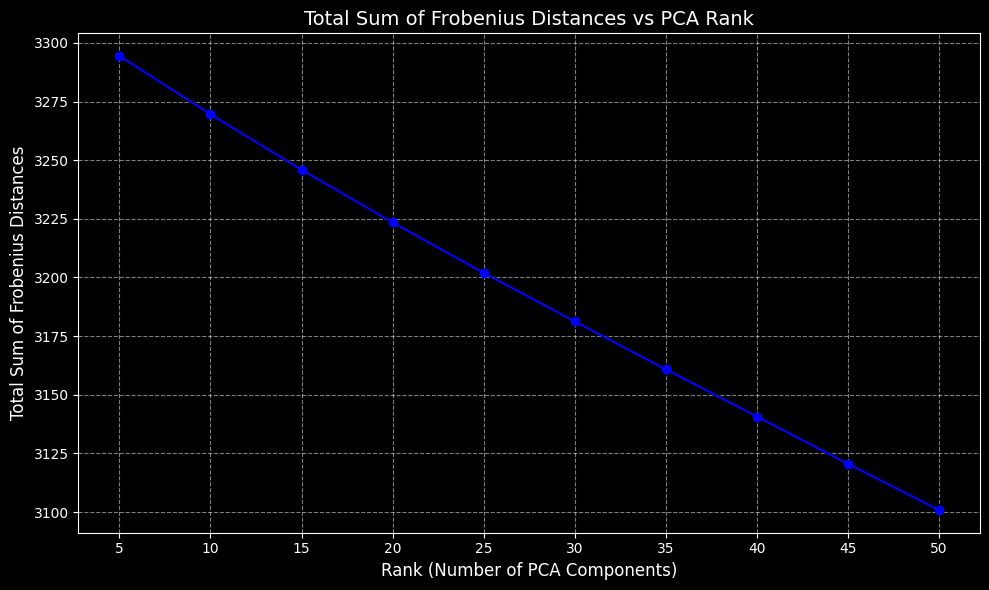

In [80]:
plot_rank_to_loss()

In [8]:
def dimensionality_reduce(matrix: np.ndarray, n_components: int = 50, standardize: bool = True):
    # Validate input dimensions
    if matrix.ndim != 2:
        raise ValueError(f"Input matrix must be 2D. Received {matrix.ndim}D.")
    
    n_samples, n_features = matrix.shape

    if n_components > n_features:
        raise ValueError(f"n_components={n_components} cannot exceed the number of features={n_features}.")

    # Standardize the data if required
    if standardize:
        scaler = StandardScaler()
        matrix_scaled = scaler.fit_transform(matrix)
    else:
        matrix_scaled = matrix.copy()

    # Initialize PCA
    pca = PCA(n_components=n_components, svd_solver='auto', random_state=42)

    # Fit PCA and transform the data
    reduced_matrix = pca.fit_transform(matrix_scaled)

    return reduced_matrix, pca


def dimensionality_reduce_list_parallel(
    matrices,
    n_components: int = 50,
    standardize: bool = True,
    n_jobs: int = -1
):
   
    def process_matrix(idx, matrix):
        try:
            reduced_matrix, pca_model = dimensionality_reduce(matrix, n_components, standardize)
            return reduced_matrix, pca_model
        except ValueError as ve:
            print(f"ValueError for matrix {idx + 1}: {ve}")
            return None, None
        except Exception as e:
            print(f"An error occurred while processing matrix {idx + 1}: {e}")
            return None, None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_matrix)(idx, matrix) for idx, matrix in enumerate(matrices)
    )

    # Unpack results
    reduced_matrices, pca_models = zip(*results)

    # Filter out any failed reductions
    reduced_matrices = [rm for rm in reduced_matrices if rm is not None]
    pca_models = [pm for pm in pca_models if pm is not None]

    return reduced_matrices

In [126]:
GM12878_M = dimensionality_reduce_list_parallel(
    GM12878_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1  # Use all available CPU cores
)

K562_M = dimensionality_reduce_list_parallel(
    K562_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

HAP1_M = dimensionality_reduce_list_parallel(
    HAP1_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

Hela_M = dimensionality_reduce_list_parallel(
    Hela_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

/Users/yanghaochong/Documents/dna_heterogeneity/.conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [9]:
bins = {
    'chr1': 250,
    'chr2': 244,
    'chr3': 198,
    'chr4': 192,
    'chr5': 181,
    'chr6': 172,
    'chr7': 160,
    'chr8': 147,
    'chr9': 142,
    'chr10': 136,
    'chr11': 135,
    'chr12': 134,
    'chr13': 97,
    'chr14': 89,
    'chr15': 83,
    'chr16': 91,
    'chr17': 82,
    'chr18': 79,
    'chr19': 60,
    'chr20': 63,
    'chr21': 40,
    'chr22': 36,
    'chrX': 154
}

def load_txt_to_matrix_fix_size(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        chr_range = bins[chr]
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1']-min_position) / 1000000)
                pos2_index = int((row['pos2']-min_position) / 1000000)
                if abs(pos1_index - pos2_index) >= 3:
                    X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

In [26]:
sample = parse_file("K562/ml3_CGCTGTCT-CGTACGTA.txt")
sample_matrix_list = load_txt_to_matrix_fix_size(sample)

In [ ]:
sample

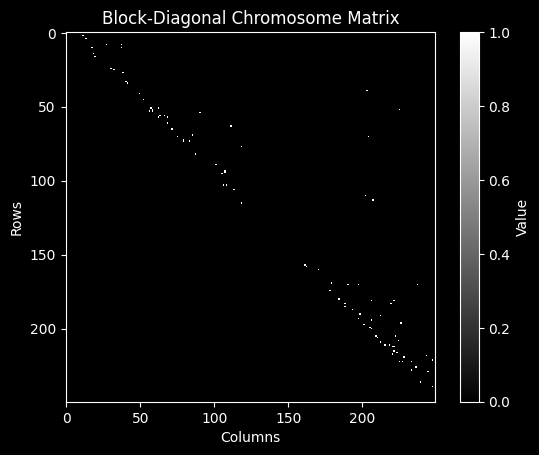

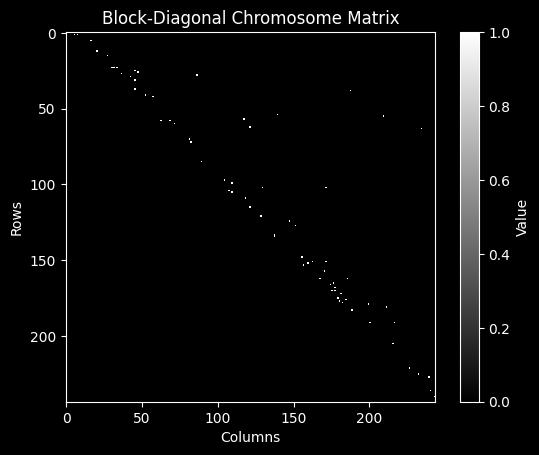

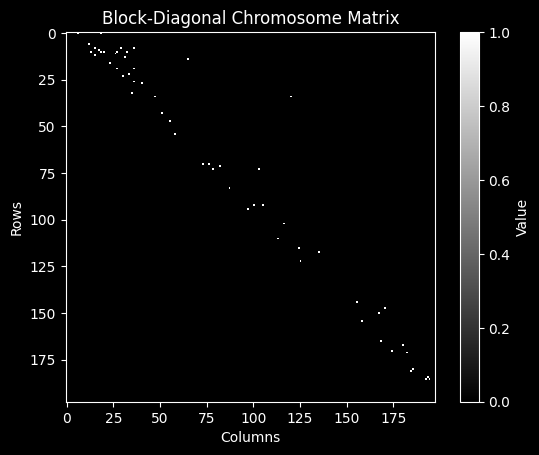

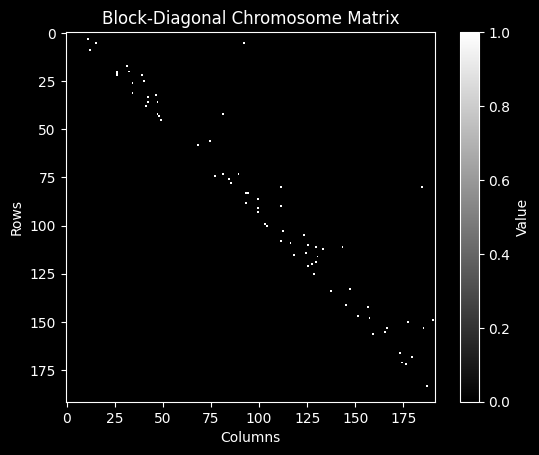

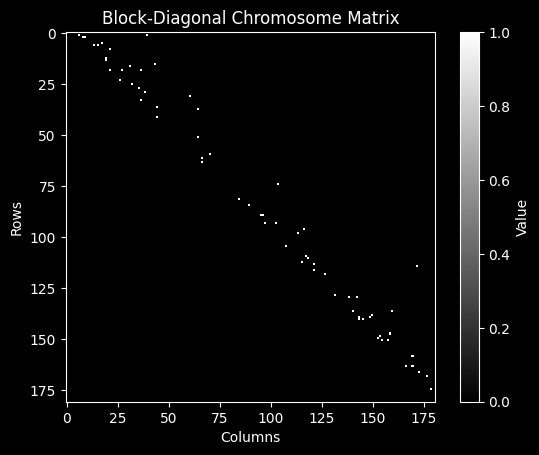

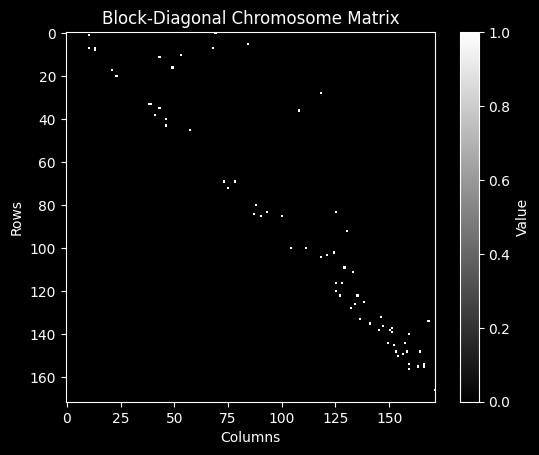

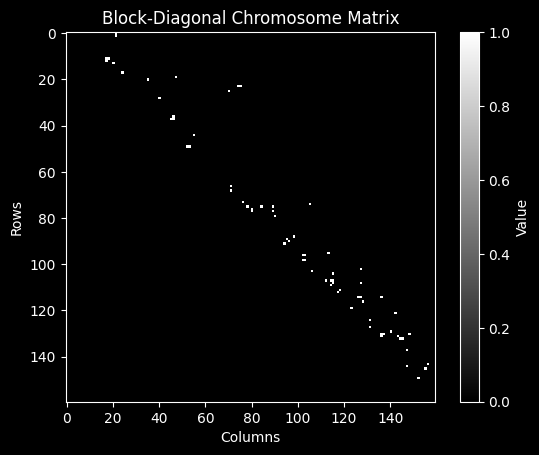

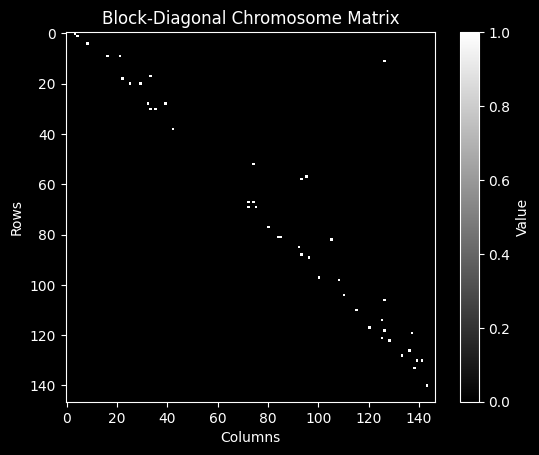

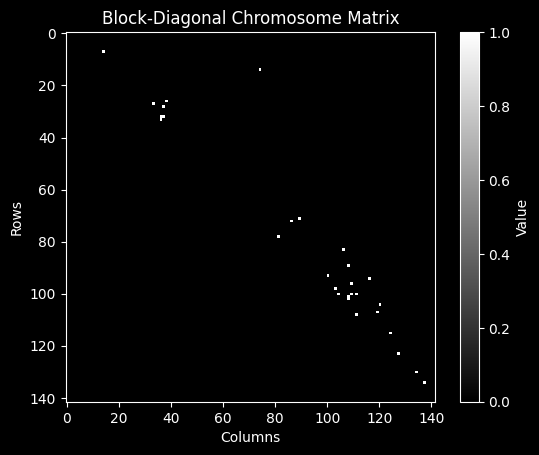

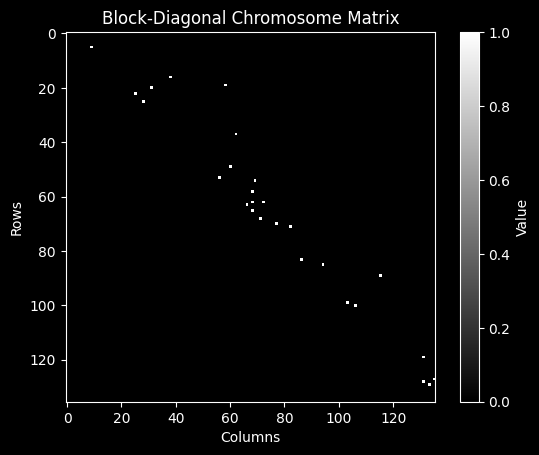

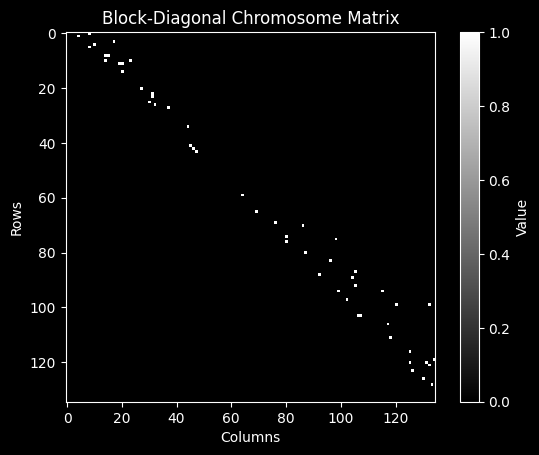

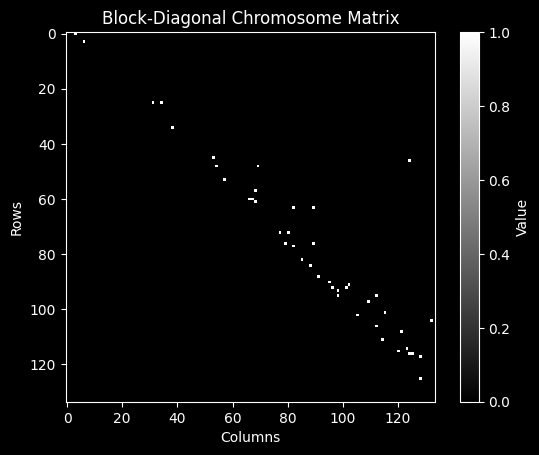

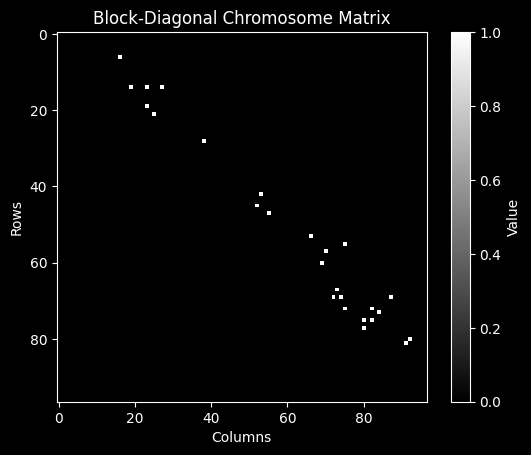

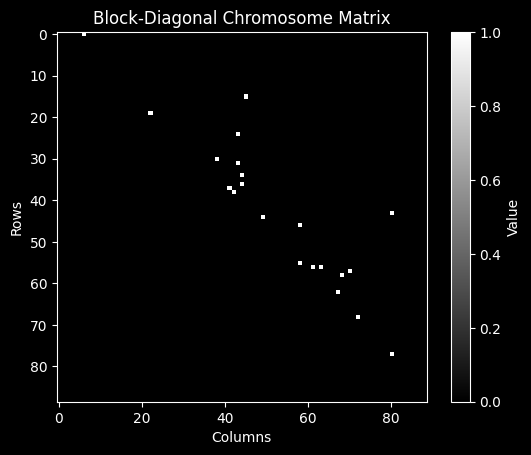

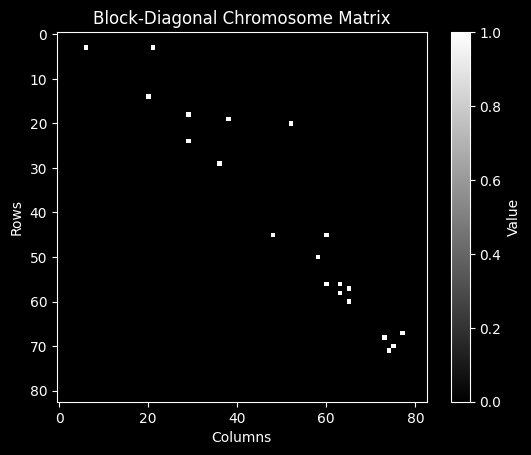

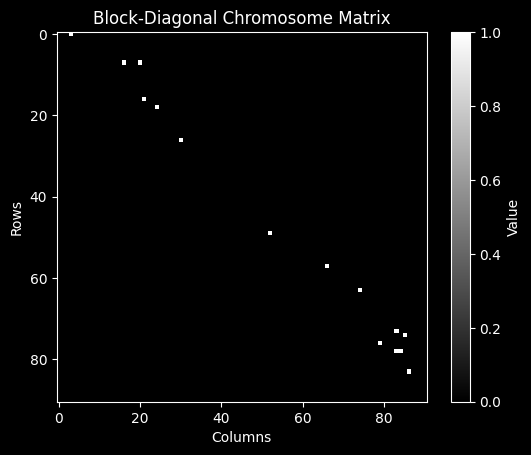

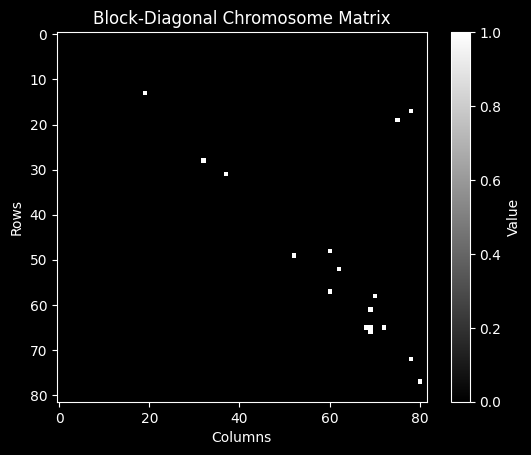

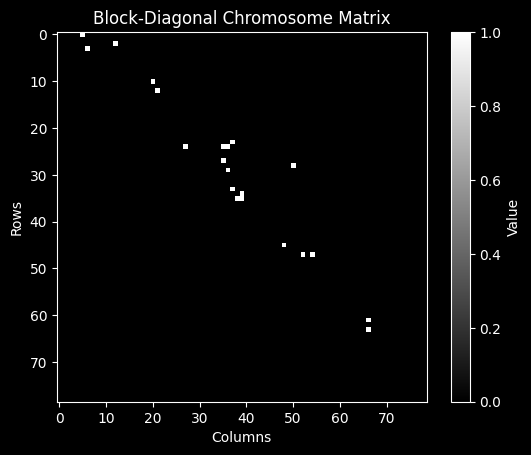

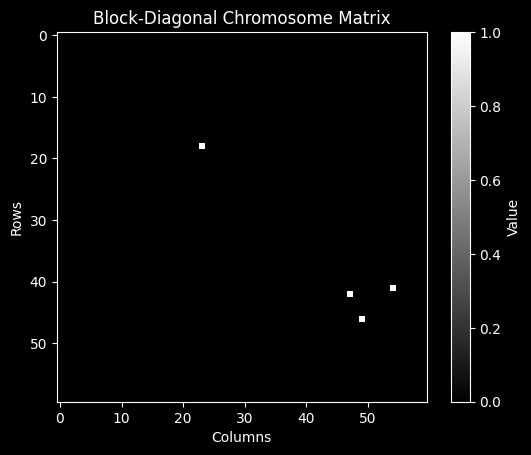

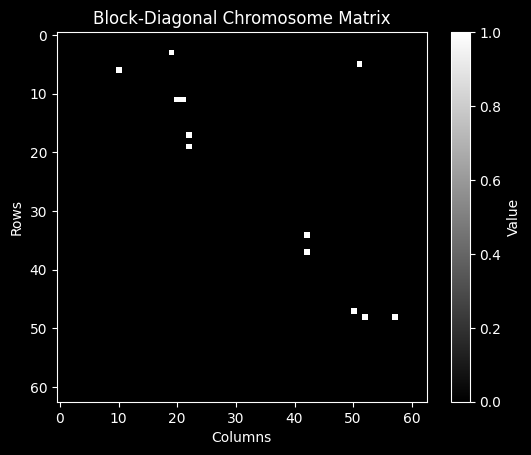

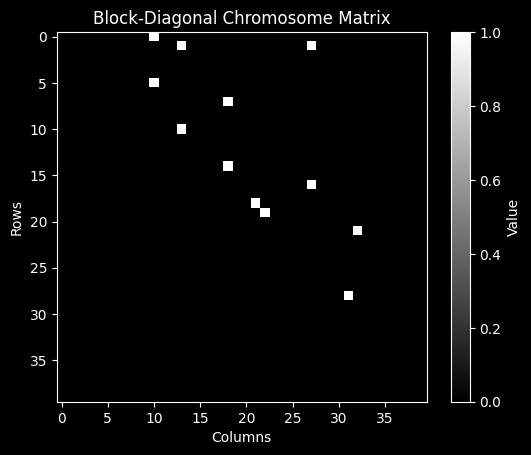

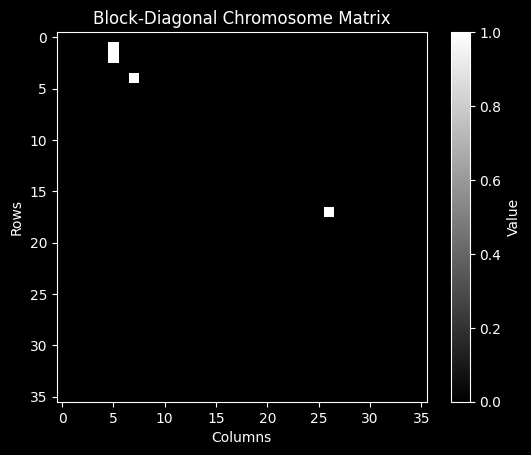

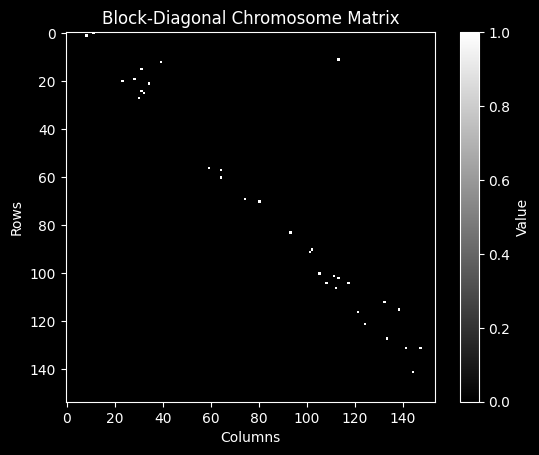

In [27]:
for i in range(23):
    visualize(sample_matrix_list[i])

In [10]:
GM12878_MATRICES_FIXED_SIZE = []
HAP1_MATRICES_FIXED_SIZE = []
Hela_MATRICES_FIXED_SIZE = []
K562_MATRICES_FIXED_SIZE = []

for file in tqdm(os.listdir("GM12878")):
    if file.endswith(".txt"):
        data = parse_file(f"GM12878/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            GM12878_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("HAP1")):
    if file.endswith(".txt"):
        data = parse_file(f"HAP1/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            HAP1_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("Hela")):
    if file.endswith(".txt"):
        data = parse_file(f"Hela/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            Hela_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

for file in tqdm(os.listdir("K562")):
    if file.endswith(".txt"):
        data = parse_file(f"K562/{file}")
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            K562_MATRICES_FIXED_SIZE.append(block_diag(matrix_in_list).toarray())

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:04<00:00,  9.87it/s]


In [11]:
sample_num = 20
# Sample a subset from HAP1 and Hela matrices
HAP1_sample = random.sample(HAP1_MATRICES_FIXED_SIZE, sample_num)
Hela_sample = random.sample(Hela_MATRICES_FIXED_SIZE, sample_num)
GM12878_sample = random.sample(GM12878_MATRICES_FIXED_SIZE, sample_num)
K562_sample = random.sample(K562_MATRICES_FIXED_SIZE, sample_num)

In [12]:
GM12878_M = dimensionality_reduce_list_parallel(
    GM12878_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1  # Use all available CPU cores
)

K562_M = dimensionality_reduce_list_parallel(
    K562_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

HAP1_M = dimensionality_reduce_list_parallel(
    HAP1_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

Hela_M = dimensionality_reduce_list_parallel(
    Hela_sample,
    n_components=50,
    standardize=True,
    n_jobs=-1
)

In [13]:
for i in range(20):
    print(GM12878_sample[i].shape, HAP1_sample[i].shape, Hela_sample[i].shape, K562_sample[i].shape)
    print(GM12878_M[i].shape, HAP1_M[i].shape, Hela_M[i].shape, K562_M[i].shape)
    print("=====")

(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 50) (2965, 50)
=====
(2965, 2965) (2965, 2965) (2965, 2965) (2965, 2965)
(2965, 50) (2965, 50) (2965, 5

In [27]:
def flatten_matrices(matrix_list):
    """
    Flattens a list of 2D matrices into a 2D array where each row is a flattened matrix.
    """
    return np.array([matrix.flatten() for matrix in matrix_list])

# Flatten the sampled matrices
HAP1_flat = flatten_matrices(HAP1_sample)
Hela_flat = flatten_matrices(Hela_sample)
GM12878_flat = flatten_matrices(GM12878_sample)
K562_flat = flatten_matrices(K562_sample)

# Combine all data into a single feature matrix
X = np.vstack((HAP1_flat, Hela_flat, GM12878_flat, K562_flat))

# Create labels for each group
labels = (
    ['HAP1'] * len(HAP1_flat) +
    ['Hela'] * len(Hela_flat) +
    ['GM12878'] * len(GM12878_flat) +
    ['K562'] * len(K562_flat)
)


In [ ]:
def plot_pca_with_cumulative_variance(
    X,
    labels,
    desired_variance=0.95,
    random_seed=None,
    figsize=(20, 8),
    palette='Set1',
    save_path=None
):
    """
    Performs PCA on the provided data and plots both the 2D PCA scatter plot
    and the cumulative variance explained plot.
    
    Parameters:
    -----------
    X : numpy.ndarray
        The feature matrix where each row corresponds to a sample and each column to a feature.
        
    labels : list or array-like
        The group labels corresponding to each sample in X.
        
    desired_variance : float, default=0.95
        The threshold for cumulative variance to determine the number of principal components.
        
    random_seed : int, optional
        Seed for the random number generator to ensure reproducibility.
        
    figsize : tuple, default=(20, 8)
        Size of the matplotlib figure.
        
    palette : str or list, default='Set1'
        Color palette for the scatter plot.
        
    save_path : str, optional
        If provided, the plot will be saved to the specified path.
        
    Returns:
    --------
    None
        Displays the plots. Optionally saves the figure if save_path is provided.
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # -------------------------------
    # Step 1: Standardize the Data
    # -------------------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # -------------------------------
    # Step 2: Perform PCA
    # -------------------------------
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Extract explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Determine the number of components needed to reach desired variance
    num_components = np.argmax(cumulative_variance >= desired_variance) + 1
    
    # -------------------------------
    # Step 3: Prepare DataFrame for Plotting
    # -------------------------------
    df_pca = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Group': labels
    })
    
    # -------------------------------
    # Step 4: Plotting
    # -------------------------------
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # --- Plot 1: 2D PCA Scatter Plot ---
    sns.scatterplot(
        ax=axes[0],
        data=df_pca,
        x='PC1',
        y='PC2',
        hue='Group',
        palette=palette,
        s=100,
        alpha=0.7
    )
    axes[0].set_title('PCA Scatter Plot', fontsize=16)
    axes[0].set_xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.1f}% Variance)', fontsize=14)
    axes[0].set_ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.1f}% Variance)', fontsize=14)
    axes[0].legend(title='Group', fontsize=12, title_fontsize=14)
    
    # --- Plot 2: Cumulative Variance Explained ---
    axes[1].plot(
        np.arange(1, len(cumulative_variance) + 1),
        cumulative_variance,
        marker='o',
        linestyle='-',
        color='b'
    )
    axes[1].axhline(y=desired_variance, color='r', linestyle='--', label=f'{desired_variance*100:.0f}% Variance')
    axes[1].axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} PCs')
    axes[1].annotate(
        f'{num_components} PCs',
        xy=(num_components, cumulative_variance[num_components - 1]),
        xytext=(num_components + 1, cumulative_variance[num_components - 1] - 0.1),
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=12
    )
    axes[1].set_title('Cumulative Variance Explained', fontsize=16)
    axes[1].set_xlabel('Number of Principal Components', fontsize=14)
    axes[1].set_ylabel('Cumulative Variance Explained', fontsize=14)
    axes[1].set_xticks(np.arange(1, len(cumulative_variance) + 1, step=1))
    axes[1].legend(fontsize=12, title_fontsize=14)
    axes[1].set_ylim(0, 1.05)
    
    plt.tight_layout()
    
    # Optionally save the figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    # Display the plot
    plt.show()
    
    # -------------------------------
    # Step 5: Print Explained Variance Details
    # -------------------------------
    print("Explained Variance by Each Principal Component:")
    for i, variance in enumerate(explained_variance_ratio, start=1):
        print(f"PC{i}: {variance*100:.2f}%")
    print(f"\nNumber of principal components to explain at least {desired_variance*100:.0f}% variance: {num_components}")

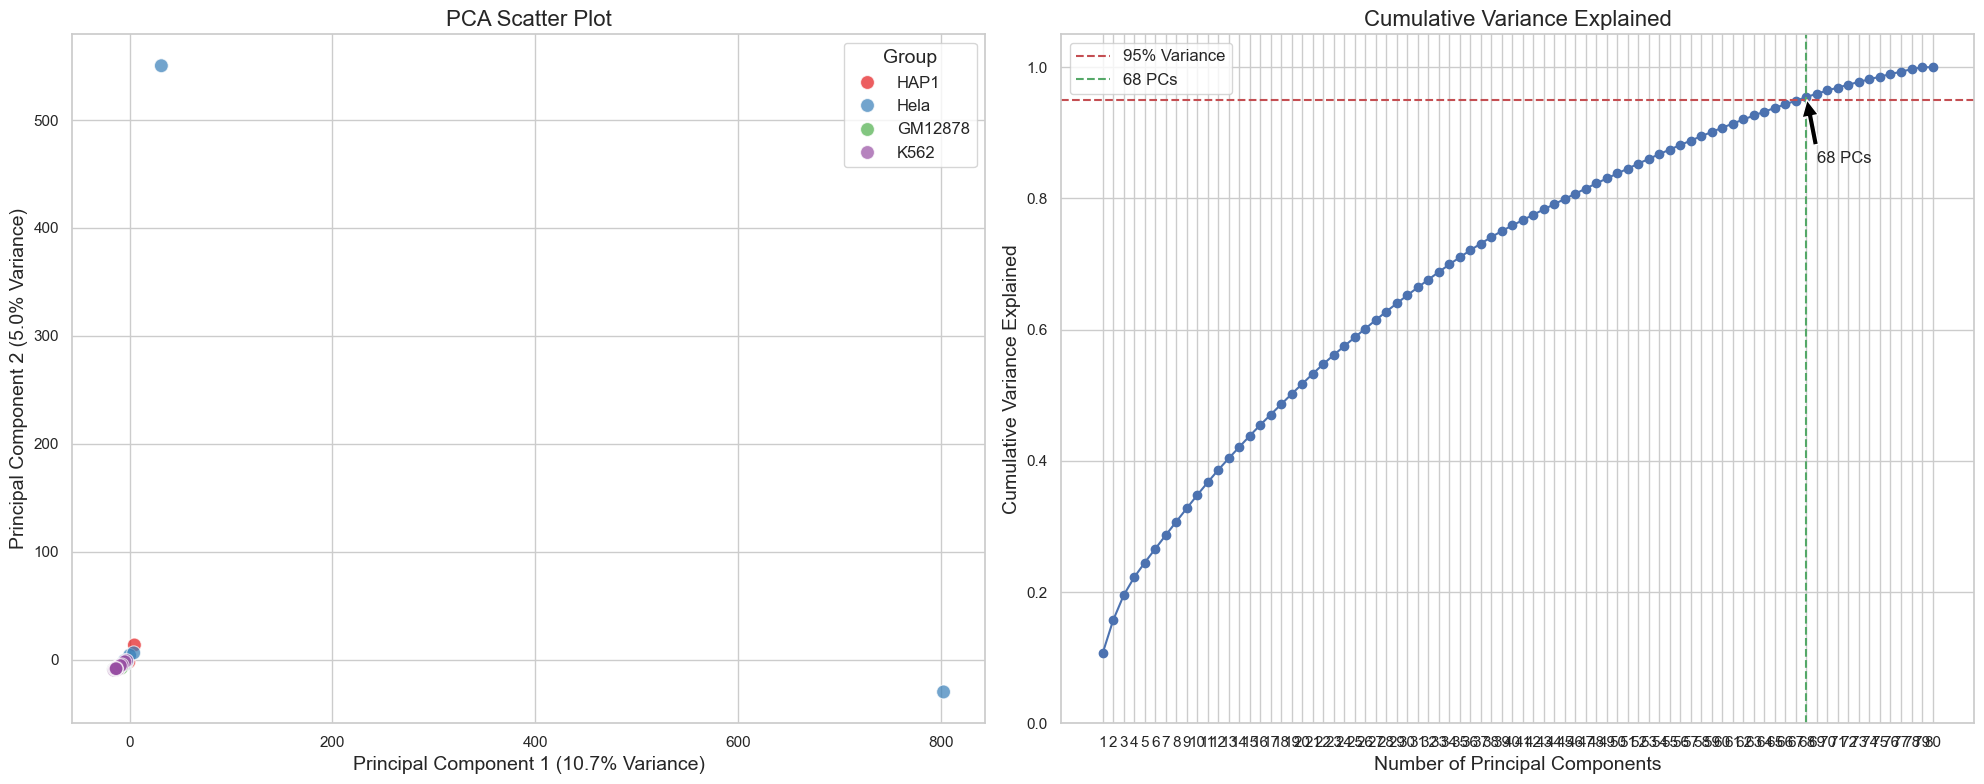

Explained Variance by Each Principal Component:
  PC1: 10.69%
  PC2: 5.03%
  PC3: 3.80%
  PC4: 2.74%
  PC5: 2.23%
  PC6: 2.10%
  PC7: 2.09%
  PC8: 2.05%
  PC9: 2.04%
  PC10: 2.02%
  PC11: 1.95%
  PC12: 1.89%
  PC13: 1.77%
  PC14: 1.72%
  PC15: 1.71%
  PC16: 1.66%
  PC17: 1.59%
  PC18: 1.58%
  PC19: 1.57%
  PC20: 1.54%
  PC21: 1.53%
  PC22: 1.49%
  PC23: 1.39%
  PC24: 1.35%
  PC25: 1.33%
  PC26: 1.33%
  PC27: 1.31%
  PC28: 1.29%
  PC29: 1.25%
  PC30: 1.23%
  PC31: 1.20%
  PC32: 1.19%
  PC33: 1.17%
  PC34: 1.15%
  PC35: 1.09%
  PC36: 1.07%
  PC37: 1.03%
  PC38: 0.98%
  PC39: 0.94%
  PC40: 0.83%
  PC41: 0.83%
  PC42: 0.82%
  PC43: 0.81%
  PC44: 0.80%
  PC45: 0.80%
  PC46: 0.79%
  PC47: 0.79%
  PC48: 0.78%
  PC49: 0.77%
  PC50: 0.75%
  PC51: 0.75%
  PC52: 0.74%
  PC53: 0.74%
  PC54: 0.72%
  PC55: 0.70%
  PC56: 0.69%
  PC57: 0.68%
  PC58: 0.66%
  PC59: 0.65%
  PC60: 0.64%
  PC61: 0.63%
  PC62: 0.62%
  PC63: 0.61%
  PC64: 0.59%
  PC65: 0.57%
  PC66: 0.55%
  PC67: 0.55%
  PC68: 0.54%
  PC69: 

In [20]:
# Call the plotting function
plot_pca_with_cumulative_variance(
    X=X,
    labels=labels,
    desired_variance=0.95,        # Desired cumulative variance threshold
    random_seed=42,               # For reproducibility
    figsize=(20, 8),              # Figure size
    palette='Set1',               # Color palette for groups
    save_path=None     # Optional: Path to save the plots
)


In [22]:
# Flatten the sampled matrices
HAP1_M_flat = flatten_matrices(HAP1_M)
Hela_M_flat = flatten_matrices(Hela_M)
GM12878_M_flat = flatten_matrices(GM12878_M)
K562_M_flat = flatten_matrices(K562_M)

# Combine all data into a single feature matrix
M = np.vstack((HAP1_M_flat, Hela_M_flat, GM12878_M_flat, K562_M_flat))

# Create labels for each group
labels = (
    ['HAP1'] * len(HAP1_M_flat) +
    ['Hela'] * len(Hela_M_flat) +
    ['GM12878'] * len(GM12878_M_flat) +
    ['K562'] * len(K562_M_flat)
)

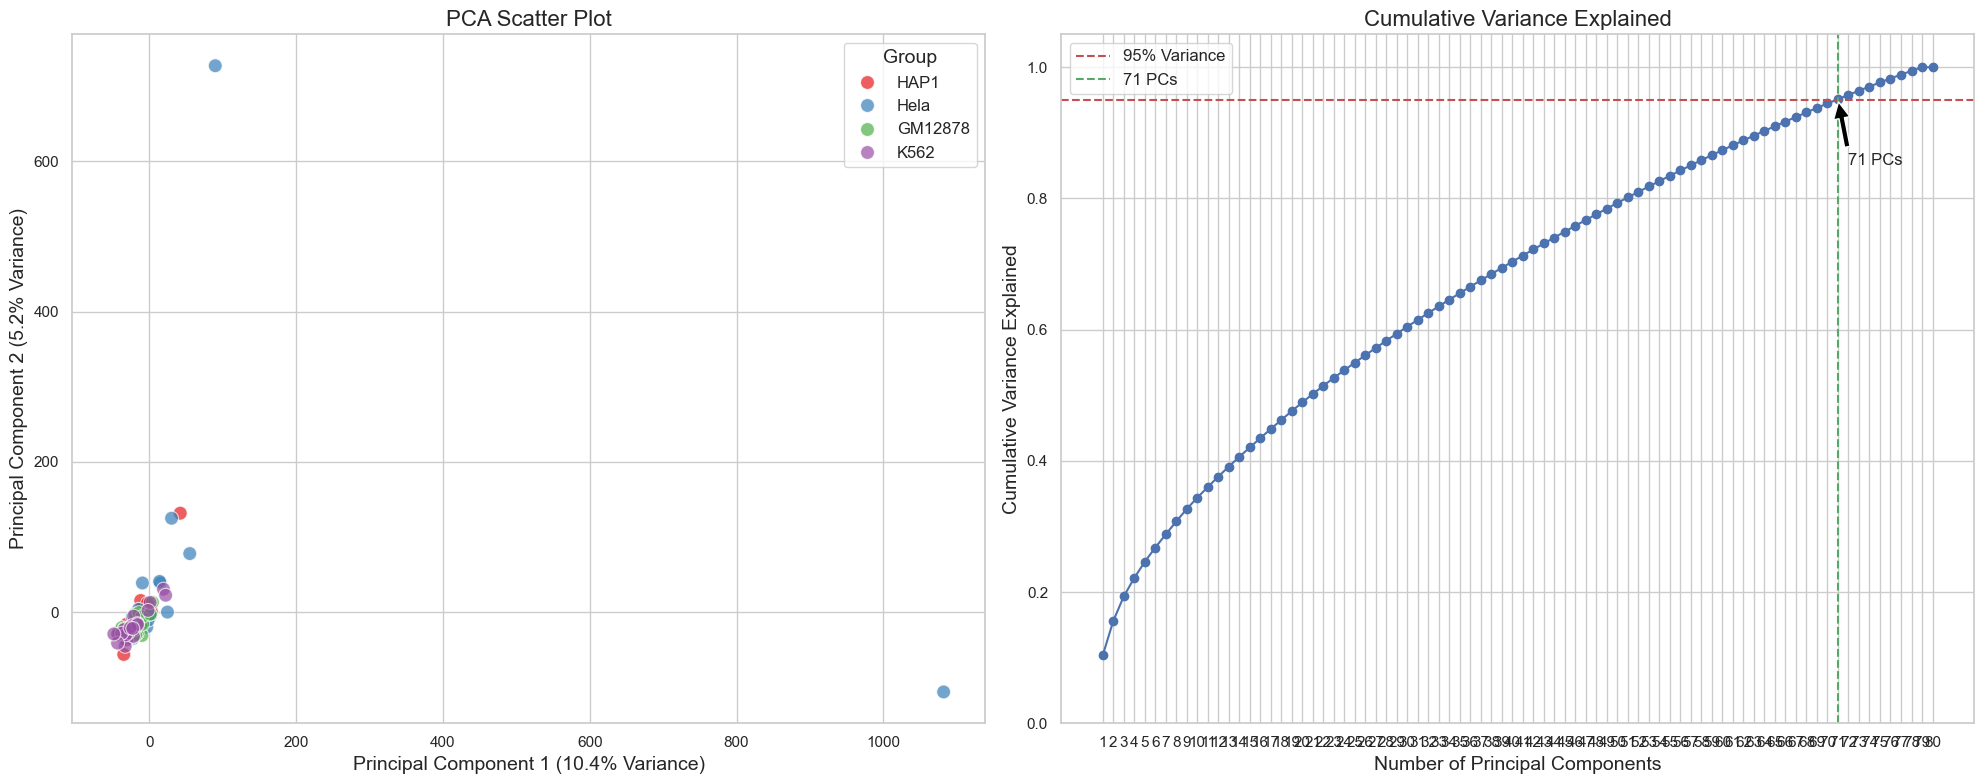

Explained Variance by Each Principal Component:
  PC1: 10.35%
  PC2: 5.22%
  PC3: 3.76%
  PC4: 2.81%
  PC5: 2.47%
  PC6: 2.17%
  PC7: 2.02%
  PC8: 1.97%
  PC9: 1.90%
  PC10: 1.72%
  PC11: 1.63%
  PC12: 1.59%
  PC13: 1.52%
  PC14: 1.49%
  PC15: 1.43%
  PC16: 1.42%
  PC17: 1.40%
  PC18: 1.37%
  PC19: 1.36%
  PC20: 1.33%
  PC21: 1.28%
  PC22: 1.25%
  PC23: 1.21%
  PC24: 1.17%
  PC25: 1.15%
  PC26: 1.13%
  PC27: 1.11%
  PC28: 1.10%
  PC29: 1.08%
  PC30: 1.06%
  PC31: 1.05%
  PC32: 1.03%
  PC33: 1.02%
  PC34: 1.01%
  PC35: 0.99%
  PC36: 0.99%
  PC37: 0.97%
  PC38: 0.96%
  PC39: 0.95%
  PC40: 0.94%
  PC41: 0.93%
  PC42: 0.93%
  PC43: 0.91%
  PC44: 0.90%
  PC45: 0.90%
  PC46: 0.89%
  PC47: 0.89%
  PC48: 0.87%
  PC49: 0.87%
  PC50: 0.86%
  PC51: 0.85%
  PC52: 0.84%
  PC53: 0.83%
  PC54: 0.82%
  PC55: 0.81%
  PC56: 0.81%
  PC57: 0.79%
  PC58: 0.78%
  PC59: 0.77%
  PC60: 0.76%
  PC61: 0.75%
  PC62: 0.74%
  PC63: 0.73%
  PC64: 0.72%
  PC65: 0.71%
  PC66: 0.71%
  PC67: 0.70%
  PC68: 0.70%
  PC69: 

In [23]:
# Call the plotting function
plot_pca_with_cumulative_variance(
    X=M,
    labels=labels,
    desired_variance=0.95,        # Desired cumulative variance threshold
    random_seed=42,               # For reproducibility
    figsize=(20, 8),              # Figure size
    palette='Set1',               # Color palette for groups
    save_path=None     # Optional: Path to save the plots
)


In [47]:
def map_chromosomes_to_indices(bins):
    chr_indices = {}
    current_start = 0
    for chr_name, bin_count in bins.items():
        start = current_start
        end = current_start + bin_count
        chr_indices[chr_name] = (start, end)
        current_start = end
    return chr_indices

def perform_multi_pc_analysis(X, n_components=5):
    """
    Perform PCA with multiple components and return combined loadings.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Input data matrix
    n_components : int
        Number of PCs to compute
        
    Returns:
    --------
    combined_loadings : numpy.ndarray
        Combined loadings from all PCs
    explained_variance_ratio : numpy.ndarray
        Explained variance ratio for each PC
    """
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Get loadings for all components
    loadings = pca.components_  # Shape: (n_components, 2965*2965)
    
    # Calculate weighted sum of loadings based on explained variance ratio
    weighted_loadings = np.zeros_like(loadings[0])
    for i in range(n_components):
        weighted_loadings += np.abs(loadings[i]) * pca.explained_variance_ratio_[i]
    
    return weighted_loadings, pca.explained_variance_ratio_

def create_chromosome_heatmaps(loadings_matrix, chromosome_bins, chr_indices, explained_variance_ratio,
                             cmap='viridis', vmin=None, vmax=None):
    """
    Creates heatmaps for each chromosome based on combined PCA loadings.
    """
    num_chromosomes = len(chromosome_bins)
    grid_size = math.ceil(math.sqrt(num_chromosomes))
    
    fig = plt.figure(figsize=(20, 22))  # Increased height for variance plot
    
    # Create subplot for explained variance
    gs = plt.GridSpec(grid_size + 1, grid_size, height_ratios=[1] * grid_size + [0.3])
    
    # Plot explained variance
    ax_var = plt.subplot(gs[-1, :])
    ax_var.bar(range(1, len(explained_variance_ratio) + 1), 
               explained_variance_ratio * 100,
               alpha=0.8)
    ax_var.set_xlabel('Principal Component')
    ax_var.set_ylabel('Explained Variance (%)')
    ax_var.set_title('Explained Variance Ratio by Principal Component')
    
    # Create heatmap subplots
    axs = []
    for i in range(grid_size):
        for j in range(grid_size):
            ax = plt.subplot(gs[i, j])
            axs.append(ax)
    
    axs = np.array(axs)
    
    # Create heatmaps
    for i, (chr_name, bins_count) in enumerate(chromosome_bins.items()):
        start, end = chr_indices[chr_name]
        
        # Extract submatrix for the chromosome
        chr_loadings = loadings_matrix[start:end, start:end]
        
        # Calculate sum of loadings over area for this chromosome
        total_loading = np.sum(chr_loadings)
        avg_loading = total_loading / (bins_count * bins_count)
        
        # Plot heatmap
        sns.heatmap(
            chr_loadings,
            ax=axs[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            xticklabels=False,
            yticklabels=False
        )
        
        # Set title with loading information
        axs[i].set_title(f'{chr_name}\nAvg Loading: {avg_loading:.2e}', fontsize=10)
        axs[i].axis('off')
    
    # Remove unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=vmin if vmin is not None else np.min(loadings_matrix),
                        vmax=vmax if vmax is not None else np.max(loadings_matrix))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Combined PCA Loading', fontsize=12)
    
    plt.suptitle(f'Chromosome-wise PCA Loadings\n(Combined from {len(explained_variance_ratio)} PCs)',
                fontsize=14, y=0.95)
    plt.tight_layout(rect=[0, 0, 0.9, 0.93])
    
    return fig

# Example usage:
def analyze_and_plot_loadings(X, bins, n_components=5, vmin=0, vmax=0.015):
    """
    Perform complete analysis and visualization of PCA loadings.
    """
    # Get chromosome indices
    chr_indices = map_chromosomes_to_indices(bins)
    
    # Perform PCA and get combined loadings
    weighted_loadings, explained_variance_ratio = perform_multi_pc_analysis(X, n_components)
    
    # Reshape loadings into a 2D matrix
    loadings_matrix = weighted_loadings.reshape((2965, 2965))
    
    # Create and display heatmaps
    fig = create_chromosome_heatmaps(
        loadings_matrix=loadings_matrix,
        chromosome_bins=bins,
        chr_indices=chr_indices,
        explained_variance_ratio=explained_variance_ratio,
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    
    return fig

/var/folders/l4/68_gb6bj02x8w61k1xskbnsw0000gn/T/ipykernel_80659/3266383086.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


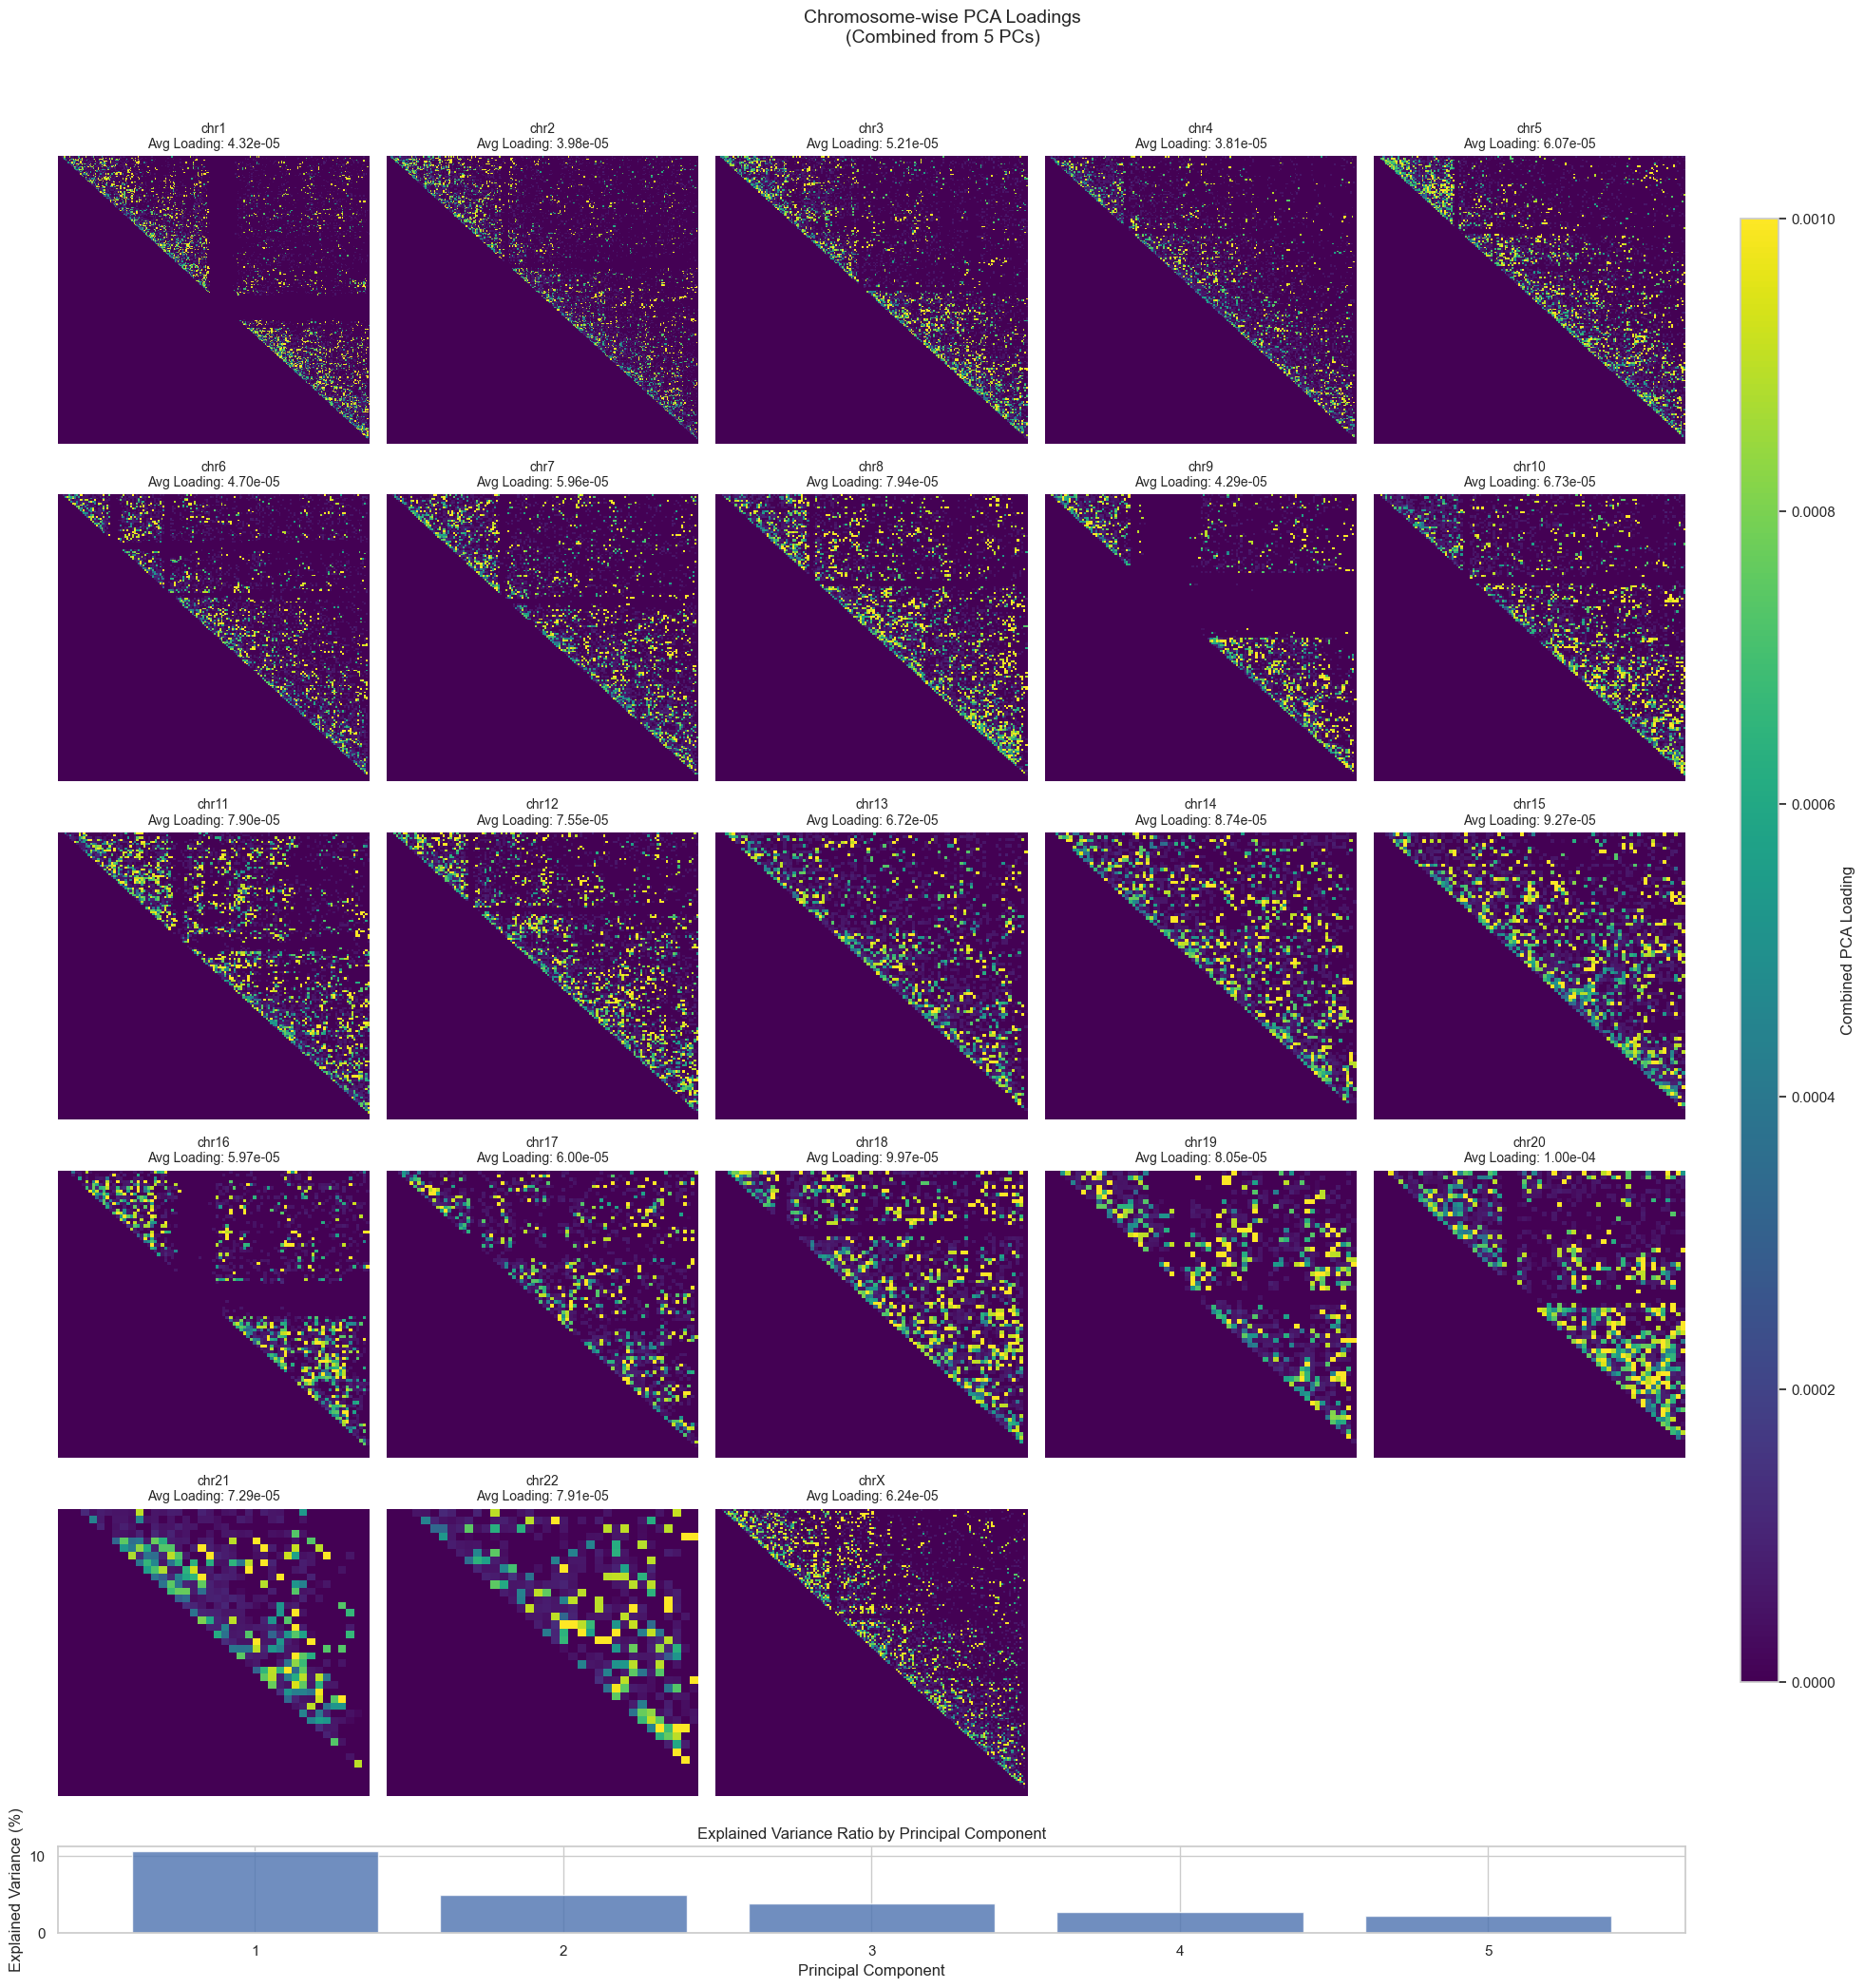

In [49]:
# For a single analysis:
fig = analyze_and_plot_loadings(X, bins, n_components=5, vmin=0, vmax=0.001)
plt.show()